In [1]:
%matplotlib inline

In [2]:
from sparapy.radiosity_fast import DRadiosityFast
from sparapy.radiosity import Radiosity, DirectionalRadiosity
import sparapy.geometry as geo
import sparapy as sp
import cProfile
import pyfar as pf
import sofar as sf
import os
import tqdm
from datetime import datetime
import numpy as np
import tracemalloc

sample_walls = sp.testing.shoebox_room_stub(1, 1, 1)

In [3]:
def init_energy(rad, source_pos):
    rad.source = geo.SoundSource(source_pos, [1, 0, 0], [0, 0, 1])
    E_matrix = []
    for patches in rad.patch_list:
        patches.init_energy_exchange(
            rad.max_order_k, rad.ir_length_s, rad.source,
            sampling_rate=rad.sampling_rate)
        E_matrix.append(patches.E_matrix)
    return E_matrix

def calc_form_factor(rad):
    if len(rad.patch_list) > 1:
        for patches in rad.patch_list:
            patches.calculate_form_factor(rad.patch_list)

def energy_exchange(rad):
    if len(rad.patch_list) > 1:
        for k in tqdm.tqdm(range(1, rad.max_order_k+1)):
            for patches in rad.patch_list:
                patches.calculate_energy_exchange(
                    rad.patch_list, k, speed_of_sound=rad.speed_of_sound,
                    E_sampling_rate=rad.sampling_rate)


In [4]:
gaussian = pf.samplings.sph_gaussian(sh_order=1)
gaussian = gaussian[gaussian.z>0]
sources = gaussian.copy()
receivers = gaussian.copy()
frequencies = pf.dsp.filter.fractional_octave_frequencies(
    1, (100, 1000))[0]
data = np.ones((sources.csize, receivers.csize, frequencies.size))
data = pf.FrequencyData(data, frequencies)
sofa = sf.Sofa('GeneralTF')
sofa.Data_Real = data.freq
sofa.Data_Imag = np.zeros_like(sofa.Data_Real)
sofa.N = data.frequencies
sofa.SourcePosition = sources.cartesian
sofa.ReceiverPosition = pf.rad2deg(receivers.spherical_elevation)
sofa_path = os.path.join(os.getcwd(), 'test.sofa')
sf.write_sofa(sofa_path, sofa)


/Users/anne/anaconda3/envs/sparapy/lib/python3.11/site-packages/pyfar/samplings/samplings.py:300: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  warnings.warn((
/Users/anne/anaconda3/envs/sparapy/lib/python3.11/site-packages/pyfar/classes/coordinates.py:136: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  warnings.warn((
/Users/anne/anaconda3/envs/sparapy/lib/python3.11/site-packages/pyfar/classes/coordinates.py:166: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((


In [5]:
n_max = 2
repeat = 2
steps_names = [
    'create patches', 'init energy', 'form factor',
    'energy exchange', 'collect energy',
    ]
steps = len(steps_names)
fast_second = np.zeros((steps, n_max, repeat))
memory_fast = np.zeros((steps, n_max, repeat))
memory_slow = np.zeros((steps, n_max, repeat))
# memory_slow[:] = np.nan
slow = np.zeros((steps, n_max, repeat))
# slow[:] = np.nan
number_of_patches = np.zeros((n_max))

# run one time, to get complied.
# radiosity = DRadiosityFast.from_polygon(sample_walls, 1)
# radiosity.init_energy([0.5, 0.5, 0.5])
# radiosity.check_visibility()
# radiosity.calculate_form_factors()
max_order_k = 5
for i in range(n_max):
    max_size = 1/(2**i)
    start_loop = datetime.now()
    print(f'{datetime.now()} run({i+1}/{n_max}): {max_size}')
    # run fast two times
    for j in range(repeat):
        # create patches and add material
        tracemalloc.start()
        start = datetime.now()
        radiosity = DRadiosityFast.from_polygon(sample_walls, max_size)

        radiosity.set_wall_scattering(
            np.arange(6), data, sources, receivers)
        radiosity.set_air_attenuation(
            pf.FrequencyData(np.zeros_like(data.frequencies), data.frequencies))
        radiosity.set_wall_absorption(
            np.arange(6),
            pf.FrequencyData(np.zeros_like(data.frequencies), data.frequencies))
        delta = (datetime.now() - start)
        memory_fast[0, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
        tracemalloc.stop()
        fast_second[0, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # form factor
        tracemalloc.start()
        start = datetime.now()
        radiosity.check_visibility()
        radiosity.calculate_form_factors()
        radiosity.calculate_form_factors_directivity()
        delta = (datetime.now() - start)
        memory_fast[2, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
        tracemalloc.stop()
        fast_second[2, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # energy exchange
        tracemalloc.start()
        start = datetime.now()
        radiosity.calculate_energy_exchange(max_order_k)
        delta = (datetime.now() - start)
        memory_fast[3, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
        tracemalloc.stop()
        fast_second[3, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # init_energy
        tracemalloc.start()
        start = datetime.now()
        radiosity.init_energy([0.5, 0.5, 0.5])
        delta = (datetime.now() - start)
        memory_fast[1, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
        tracemalloc.stop()
        fast_second[1, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # collect energy
        tracemalloc.start()
        start = datetime.now()
        radiosity.collect_energy_receiver(np.array([0.5, 0.5, 0.5]))
        delta = (datetime.now() - start)
        memory_fast[4, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
        tracemalloc.stop()
        fast_second[4, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

    number_of_patches[i] = radiosity.n_patches
    if i < 4:
        # Run old
        for j in range(repeat):
            # create patches
            tracemalloc.start()
            start = datetime.now()
            radiosity_old = DirectionalRadiosity(
                sample_walls, max_size, max_order_k, 1, sofa_path)
            delta = (datetime.now() - start)
            slow[0, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
            memory_slow[0, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()

            # init_energy
            tracemalloc.start()
            start = datetime.now()
            E_matrix = init_energy(radiosity_old, [0.5, 0.5, 0.5])
            delta = (datetime.now() - start)
            slow[1, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
            memory_slow[1, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()

            # form factor
            tracemalloc.start()
            start = datetime.now()
            calc_form_factor(radiosity_old)
            delta = (datetime.now() - start)
            slow[2, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
            memory_slow[2, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()

            # energy exchange
            tracemalloc.start()
            start = datetime.now()
            energy_exchange(radiosity_old)
            delta = (datetime.now() - start)
            slow[3, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
            memory_slow[3, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()

            # collect energy
            tracemalloc.start()
            start = datetime.now()
            receiver = sp.geometry.Receiver([0.5, 0.5, 0.5], [1, 0, 0], [0, 0, 1])
            radiosity_old.energy_at_receiver(receiver)
            delta = (datetime.now() - start)
            slow[4, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
            memory_slow[4, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()
    delta = (datetime.now() - start_loop)
    delta_seconds = (delta.seconds*1e6 + delta.microseconds)*1e-6
    print(f'{datetime.now()}   took {delta_seconds} seconds')


2024-06-03 10:54:11.924055 run(1/2): 1.0


/var/folders/7q/_50y0lw50_x1j732_5yyyx7h0000gn/T/ipykernel_12807/1267676870.py:33: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity.set_wall_scattering(
/var/folders/7q/_50y0lw50_x1j732_5yyyx7h0000gn/T/ipykernel_12807/1267676870.py:33: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity.set_wall_scattering(
/Users/anne/git/_pyfar/sparapy/sparapy/radiosity.py:60: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums
/Users/anne/git/_pyfar/sparapy/sparapy/radiosity.py:1099: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  polygon_list[i], PatchesDirectional) else PatchesDirectional.from_sofa(
100%|██████████| 5/5 [00:00<00:00, 15.45it/s]
/Users/anne/git/_pyfar/sparapy/sparapy/radiosity.py:1193: RuntimeWarning: divide by ze

2024-06-03 10:54:35.610042   took 23.685983 seconds
2024-06-03 10:54:35.610079 run(2/2): 0.5


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]

2024-06-03 10:55:06.781480   took 31.1714 seconds


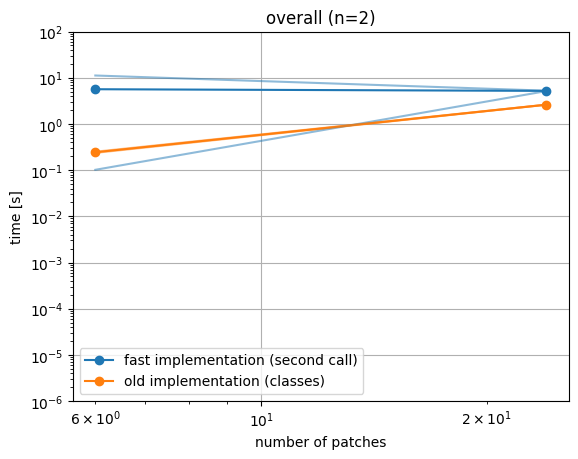

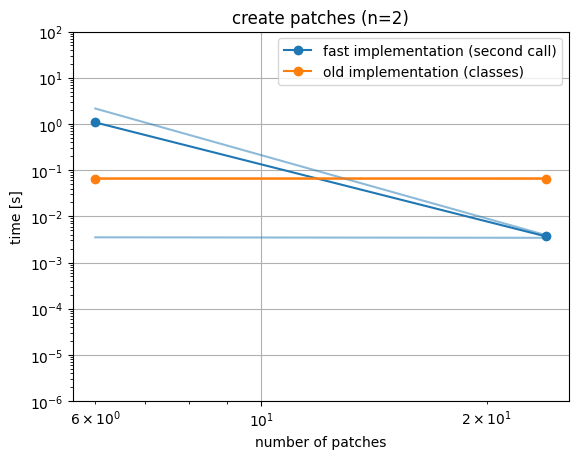

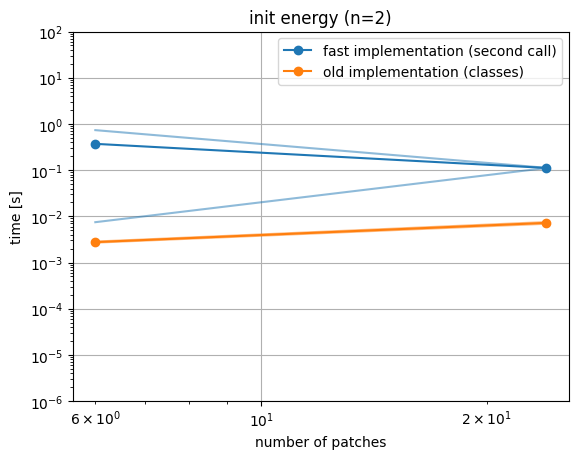

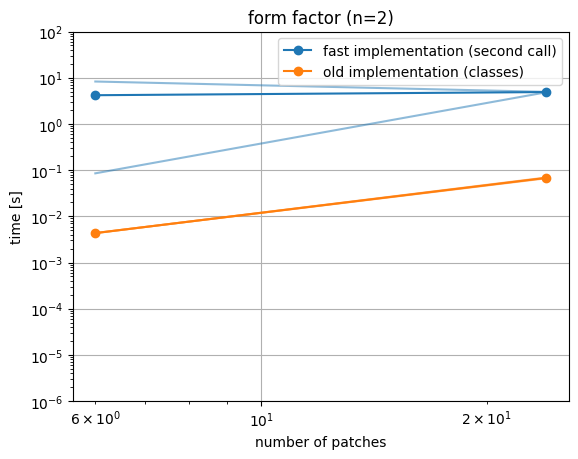

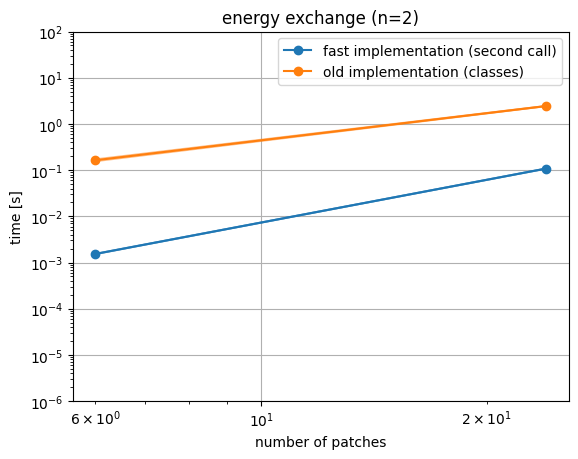

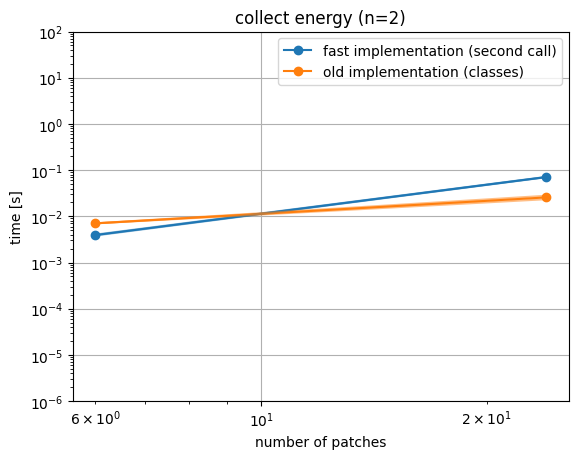

In [6]:
import matplotlib.pyplot as plt
slow[slow == 0] = np.nan
# plot time to compute
plt.figure()
ax = plt.gca()
ax.semilogy(
    number_of_patches, np.mean(np.sum(fast_second, axis=0)*1e-6, axis=-1),
    label='fast implementation (second call)', marker='o')
ax.semilogy(
    number_of_patches, np.mean(np.sum(slow, axis=0)*1e-6, axis=-1),
    label='old implementation (classes)', marker='o')
ax.semilogy(
    number_of_patches, np.sum(fast_second, axis=0)*1e-6, color='C0', alpha=0.5)
ax.semilogy(
    number_of_patches, np.sum(slow, axis=0)*1e-6, color='C1', alpha=0.5)
ax.grid()
ax.set_xscale('log')
ax.set_xlabel('number of patches')
ax.set_ylabel('time [s]')
ax.set_title(f'overall (n={repeat})')
ax.set_ylim([1e-6, 1e2])
plt.legend()

for i in range(steps):
    plt.figure()
    ax = plt.gca()

    ax.semilogy(
        number_of_patches, np.mean(fast_second[i]*1e-6, axis=-1),
        label='fast implementation (second call)', marker='o')
    ax.semilogy(
        number_of_patches, np.mean(slow[i]*1e-6, axis=-1),
        label='old implementation (classes)', marker='o')
    ax.semilogy(
        number_of_patches, fast_second[i]*1e-6, color='C0', alpha=0.5)
    ax.semilogy(
        number_of_patches, slow[i]*1e-6, color='C1', alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel('number of patches')
    ax.set_ylabel('time [s]')
    ax.set_title(f'{steps_names[i]} (n={repeat})')
    ax.set_ylim([1e-6, 1e2])
    plt.legend()

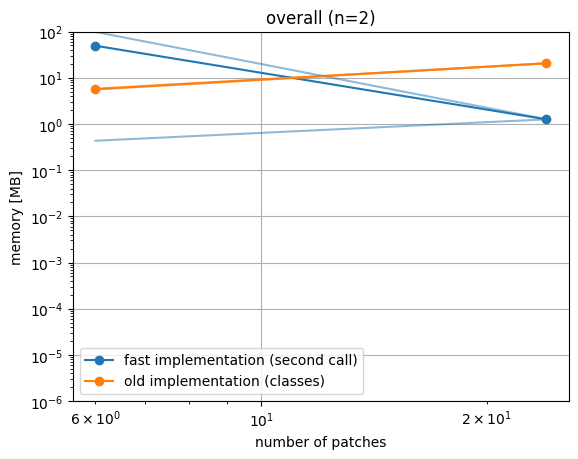

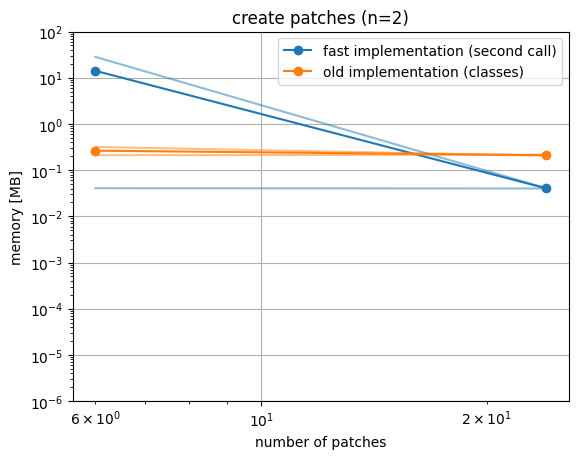

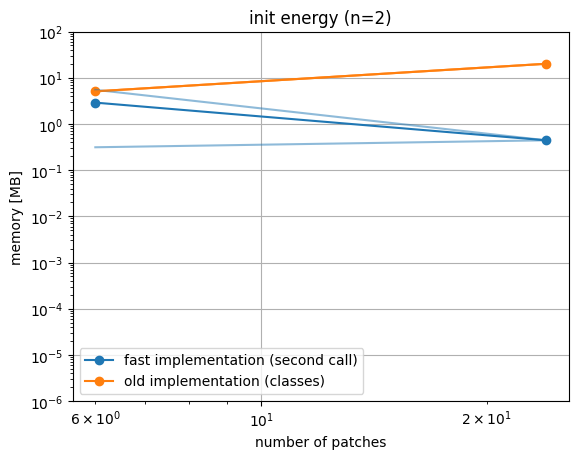

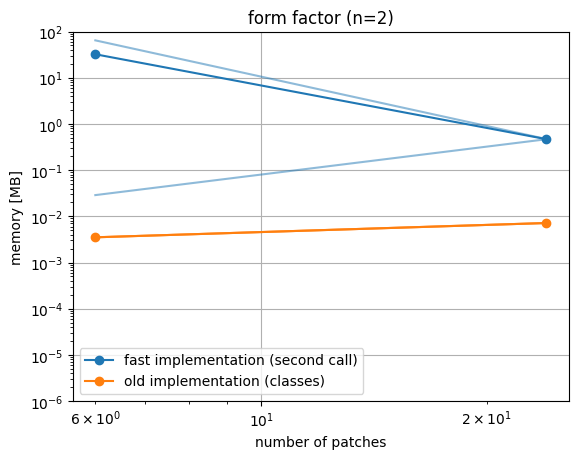

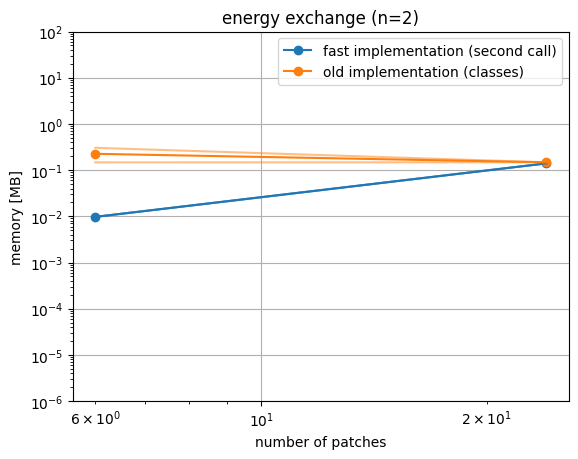

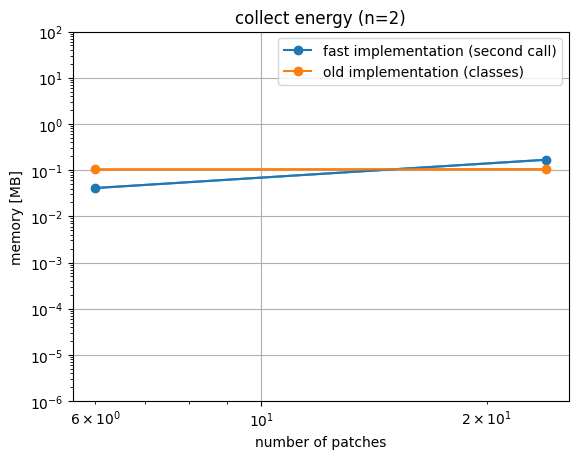

In [15]:
# plot memory consumption
memory_slow[memory_slow == 0] = np.nan

plt.figure()
ax = plt.gca()
ax.semilogy(
    number_of_patches, np.mean(np.sum(memory_fast, axis=0)*1e-6, axis=-1),
    label='fast implementation (second call)', marker='o')
ax.semilogy(
    number_of_patches, np.mean(np.sum(memory_slow, axis=0)*1e-6, axis=-1),
    label='old implementation (classes)', marker='o')
ax.semilogy(
    number_of_patches, np.sum(memory_fast, axis=0)*1e-6, color='C0', alpha=0.5)
ax.semilogy(
    number_of_patches, np.sum(memory_slow, axis=0)*1e-6, color='C1', alpha=0.5)
ax.grid()
ax.set_xscale('log')
ax.set_xlabel('number of patches')
ax.set_ylabel('memory [MB]')
ax.set_title(f'overall (n={repeat})')
ax.set_ylim([1e-6, 1e2])
plt.legend()

for i in range(steps):
    plt.figure()
    ax = plt.gca()

    ax.semilogy(
        number_of_patches, np.mean(memory_fast[i]*1e-6, axis=-1),
        label='fast implementation (second call)', marker='o')
    ax.semilogy(
        number_of_patches, np.mean(memory_slow[i]*1e-6, axis=-1),
        label='old implementation (classes)', marker='o')
    ax.semilogy(
        number_of_patches, memory_fast[i]*1e-6, color='C0', alpha=0.5)
    ax.semilogy(
        number_of_patches, memory_slow[i]*1e-6, color='C1', alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel('number of patches')
    ax.set_ylabel('memory [MB]')
    ax.set_title(f'{steps_names[i]} (n={repeat})')
    ax.set_ylim([1e-6, 1e2])
    plt.legend()

In [8]:
r = np.sum(radiosity.form_factors==0) / radiosity.form_factors.size
print(f'ratio of zeros of form factors: {r*100:.2f}%')

ratio of zeros of form factors: 58.33%


In [9]:
import sofar as sf
sofa = sf.Sofa('FreeFieldDirectivityTF')
sofa.Data_Real = np.zeros_like(sofa.Data_Real)
sofa.Data_Imag = np.zeros_like(sofa.Data_Imag)

In [10]:
sofa.inspect()

FreeFieldDirectivityTF 1.1 (SOFA version 2.1)
----------------------------------------------
GLOBAL_Conventions : SOFA
GLOBAL_Version : 2.1
GLOBAL_SOFAConventions : FreeFieldDirectivityTF
GLOBAL_SOFAConventionsVersion : 1.1
GLOBAL_DataType : TF
GLOBAL_RoomType : free field
GLOBAL_Title : 
GLOBAL_DateCreated : 2024-06-03 10:55:09
GLOBAL_DateModified : 2024-06-03 10:55:09
GLOBAL_APIName : sofar SOFA API for Python (pyfar.org)
GLOBAL_APIVersion : sofar v1.1.3 implementing SOFA standard AES69-2022 (SOFA conventions 2.1)
GLOBAL_AuthorContact : 
GLOBAL_Organization : 
GLOBAL_License : No license provided, ask the author for permission
GLOBAL_ApplicationName : Python
GLOBAL_ApplicationVersion : 3.11.9 [CPython - Clang 14.0.6 ]
GLOBAL_Comment : 
GLOBAL_History : 
GLOBAL_References : 
GLOBAL_Origin : 
GLOBAL_DatabaseName : 
GLOBAL_Musician : 
GLOBAL_Description : 
GLOBAL_SourceType : 
GLOBAL_SourceManufacturer : 
GLOBAL_EmitterDescription : 
ListenerPosition : (I=1, C=3)
  [0 0 0]
ListenerPosit

In [11]:
sofa.Data_Real

array(0)

In [12]:
sofa.Data_Real.shape


()